In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler

In [17]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

In [18]:
def _plot_cm(y_true, y_pred, ax, ax_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap='cubehelix', vmin=0, vmax=1)
    plt.xticks(range(len(ax_labels)), ax_labels)
    plt.yticks(range(len(ax_labels)), ax_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    ax.set_title(title)
    return im

def plot_cm(y_true, y_pred, y_shuffle_true, y_shuffle_pred):
    '''
    plot confusion matrix

    Args:
        y_true ([np.array]): array for true label
        y_pred ([np.array]): array for predicted label
        y_shuffle_true ([np.array]): array for shffuled label
        y_shuffle_pred ([np.array]): array for shuffled predicted label
    '''
    fig = plt.figure(figsize=(23, 10), facecolor='white')
    gs = GridSpec(ncols=3, nrows=1, wspace=0.1, figure = fig, width_ratios=[10,10,0.3])
    fig_ax = fig.add_subplot(gs[0,0])
    labels = np.unique(y_true)
    _plot_cm(y_true, y_pred, fig_ax, labels, f'Real Accuracy {accuracy_score(y_true, y_pred):0.2f}')

    fig_ax = fig.add_subplot(gs[0,1])
    im = _plot_cm(y_shuffle_true, y_shuffle_pred, fig_ax, labels, f'Shuffle Accuracy {accuracy_score(y_shuffle_true, y_shuffle_pred):0.2f}')
    fig_ax.set_ylabel('')
    fig_ax.set_yticklabels([])

    # plot colorbar
    cb = fig.add_subplot(gs[0,2])
    fig.colorbar(mappable=im, cax=cb, label='Fraction of labels', )
    fig.tight_layout()
    plt.show()
    c = PlotConfig()
    #fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'age_decoder_confusion_pre.pdf')

In [19]:
format_plots()
#format_pizza_plots()

In [20]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [21]:
## update data
def remove_crl(df):
    max=46
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    #df.drop('b365ea6a-369f-4991-b139-15694dc1c86d',level=3, axis=0, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [22]:
# remapped to bins
mapdr_females = {0: 3, 
       1: 5, 
       2: 7,
       3: 9,
       4: 12,
       5: 24,
       6: 36,
       7: 52,
       8: 72,
       9: 90,
       }

mapdr_males = {0: 3, 
       1: 5, 
       2: 7,
       3: 9,
       4: 12,
       5: 24,
       6: 36,
       7: 52,
       8: 78,
       9: 90,
       }

In [23]:
# arrange data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_females_clean_v2.parquet')
f_psd = pd.read_parquet(path)
f_psd= remove_crl(f_psd)

# pseudo data males
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_males_clean_pseudotime_v02.parquet')
m_psd = pd.read_parquet(path)
m_psd=m_psd.reset_index()
m_psd=m_psd[['uuid','pseudotime_rank','age']]

#make sure only animals in clean v2 are in the male dataframe:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_males_clean_v2.parquet')
df_males = pd.read_parquet(path)
df_males = remove_crl(df_males)
m_psd = df_males.merge(m_psd, on='uuid', how='left')

#do some cleaning up
m_psd.rename(columns={'pseudotime_rank': 'psd'}, inplace=True)
m_psd.set_index(['psd','uuid','age'], append=True, inplace=True)
m_psd = m_psd.filter(regex=r'\d')

In [24]:
# pseudo regression
from sklearn.cross_decomposition import PLSRegression
from sklearn import neighbors
mdl= neighbors.KNeighborsRegressor(n_neighbors=8)
mdl = PLSRegression(n_components=3)
x = m_psd.filter(regex=r'\d')
y = x.index.get_level_values('psd')
mdl.fit(x, y)
print(mdl.score(x, y))

#if you want to log transform
#x = np.log(x + 1e-6) # convert to linear
x = f_psd.filter(regex=r'\d')
f_psd['psd']=mdl.predict(x)

0.9553997342803521


In [25]:
# to convert pseudo time into bins the lengh of the bins of cross-sectional data and remap:
# females
f_psd['bins'] = pd.qcut(f_psd['psd'], len(f_psd.index.get_level_values('age').unique()),labels=False)
y_psd=f_psd['bins'].to_numpy()
y_psd = [mapdr_females[item] for item in y_psd]
f_psd['remapped_bins'] = y_psd
f_psd.set_index(['remapped_bins','bins','psd'], append=True, inplace=True)

In [26]:
# add the original pseudotime
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_females_clean_pseudotime_v02.parquet')
df_temp = pd.read_parquet(path)
df_temp = df_temp[~df_temp.index.get_level_values('session_name').str.contains('CRL')]
df_temp = df_temp.reset_index()

#get bins and remap bins
df_temp['fpsd_bins'] = pd.qcut(df_temp['pseudotime_rank'], len(df_temp['age'].unique()),labels=False)
df_temp = df_temp.rename(columns={'pseudotime_rank': 'fpsd'})
y_temp = df_temp['fpsd_bins'].to_numpy()
y_temp = [mapdr_females[item] for item in y_temp]
df_temp['fpsd_remapped_bins'] = y_temp
df_temp=df_temp[['uuid','fpsd','fpsd_bins','fpsd_remapped_bins']]

#merge with female dataframe
f_psd = pd.merge(f_psd.reset_index(),df_temp,how='left',on=['uuid'])
f_psd.set_index(['age','uuid','psd','bins','remapped_bins','fpsd','fpsd_bins','fpsd_remapped_bins'], 
                append=False, inplace=True)
f_psd = f_psd.filter(regex=r'\d')

In [27]:
## convert male pseudotime to bins and remap the bins
m_psd['bins'] = pd.qcut(m_psd.index.get_level_values('psd'), len(m_psd.index.get_level_values('age').unique()),labels=False)
y_temp = m_psd['bins'].to_numpy()
y_temp = [mapdr_males[item] for item in y_temp]
m_psd['remapped_bins'] = y_temp
m_psd.set_index(['bins','remapped_bins'], 
                append=True, inplace=True)

In [28]:
m_data = m_psd.query('remapped_bins != 90').copy()
m_data['sex'] = 'm'
f_data = f_psd.query('remapped_bins != 90').copy()
f_data['sex'] = 'f'

In [29]:
m_data=m_data.reset_index()
m_data.set_index(['uuid','bins','remapped_bins','age','sex'], inplace=True)
m_data = m_data.filter(regex=r'\d')

f_data=f_data.reset_index()
f_data['remapped_bins'][f_data.remapped_bins==72]=78
f_data.set_index(['uuid','bins','remapped_bins','age','sex'], inplace=True)
f_data = f_data.filter(regex=r'\d')

In [30]:
data=pd.concat([m_data,f_data]).drop('level_0', axis=1)

In [31]:
# choose a model for decoder
# choose a model for decoder
clf = svm.SVC(kernel='linear') 
#clf = RandomForestClassifier(n_estimators = 200)
#clf = LinearRegression()
#clf = KNeighborsRegressor(n_neighbors=5)

# choose cross validation scheme
cv = LeaveOneOut()
#cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
#cv=5

#number of iterations for shuffle
it=1000

In [32]:
sh_ages=[]
age2=[]
acc=[]
sh_acc=[]
for age,_df in enumerate(data.groupby('remapped_bins')):
    #ages.extend(_df[1].index.get_level_values('remapped_bins').to_numpy())
    age2.append(_df[0])
    x = _df[1].to_numpy()
    x = np.log(x + 1e-6)
    y=_df[1].index.get_level_values('sex')
    y_pred = cross_val_predict(clf, x, y, cv=cv)
    acc.append(np.mean(cross_val_score(clf, x, y, cv=cv)))
    for i in tqdm(range(it)):
        sh_ages.append(_df[0])
        ysh_temp=np.random.permutation(y)
        sh_acc.append(np.mean(cross_val_score(clf, x, ysh_temp, cv=cv)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:13<00:00, 13.55it/s]


In [33]:
# create df for plotting
df_sh = pd.DataFrame()
df_sh['acc']=sh_acc
df_sh['ages'] = sh_ages

df = pd.DataFrame()
df['acc']=acc
df['ages'] = age2

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

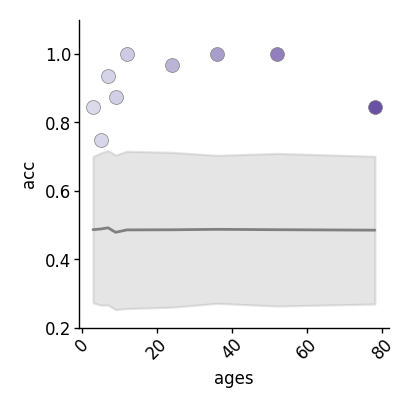

In [39]:
fig, ax = plt.subplots(figsize=(2, 2))
#sns.violinplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray')
sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray', estimator='mean', errorbar=('sd', 2))
#sns.pointplot(data=df, x="ages", y="acc",
              #xticklabels=1,
              #dodge=0, 
#              join=False, 
#              ax=ax, 
#              scale=1,
#              hue='ages',
 #             palette='Blues',
              #edgecolor='gray',
              #linewidth=0.3
 #            )
#sns.lineplot(data=df, x="ages", y="acc", ax=ax, color='gray')
sns.lineplot (data=df, x='ages', y='acc', 
              markers=True, 
              marker='o',
              markersize=5,
              palette = cmm,
              hue='ages',
              linestyle='-',
              markeredgecolor='grey', 
              markeredgewidth=0.25,
             legend=False)
plt.ylim([0.2,1.1])
plt.legend([],[], frameon=False)
sns.despine()
plt.xticks(rotation=45)
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4_ontogeny_females"/ 'fvm_sex_decoder.pdf', bbox_inches='tight')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '3'),
  Text(1, 0, '5'),
  Text(2, 0, '7'),
  Text(3, 0, '9'),
  Text(4, 0, '12'),
  Text(5, 0, '24'),
  Text(6, 0, '36'),
  Text(7, 0, '52'),
  Text(8, 0, '78')])

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

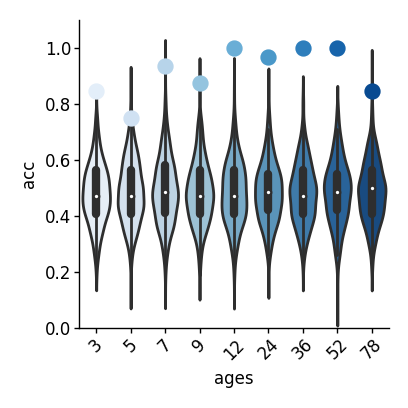

In [205]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.violinplot(data=df_sh, x="ages", y="acc", ax=ax, 
               #color='gray', 
               palette = 'Blues', 
               fill = False,
                inner_kws=dict(box_width=15, whis_width=2, color=".8"),
               #hue='ages',
              )
#sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray', estimator='mean', errorbar=('sd', 2))
sns.pointplot(data=df, x="ages", y="acc",
              #xticklabels=1,
              dodge=0, 
              join=False, 
              ax=ax, 
              scale=1,
              hue='ages',
             palette='Blues',
              #edgecolor='gray',
              #linewidth=0.3
            )

plt.ylim([0,1.1])
plt.legend([],[], frameon=False)
sns.despine()
plt.xticks(rotation=45)